In [77]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [71]:
dataset = fetch_california_housing()

X = dataset.data
y = dataset.target
columns = dataset.feature_names
print(columns)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [73]:
df = pd.DataFrame(X, columns=columns)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [79]:
from sklearn.model_selection import train_test_split

In [80]:
trainX, testX, trainy, testy = train_test_split(df, y, test_size=0.25)

In [81]:
from sklearn.ensemble import RandomForestRegressor

In [82]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(trainX, trainy)

RandomForestRegressor()

In [83]:
from sklearn.metrics import mean_squared_error

In [84]:
print("R2-Score", rf.score(testX, testy))
print("RMSE", mean_squared_error(rf.predict(testX), testy, squared=False))

R2-Score 0.8050641555433672
RMSE 0.5124355312655898


In [85]:
predictions = rf.predict(testX)
z = list(zip(predictions, testy))
z.sort(key=(lambda x: x[1]))  # sort based on test value
predictions, testy = list(zip(*z))

In [86]:
import matplotlib.pyplot as plt

In [87]:
def plot_sorted_results(pre, lab):
    plt.plot(pre, label="Predictions")
    plt.plot(lab, label="True Value")
    plt.legend()
    plt.ylabel("House Value (in 100,000s)")
    plt.show()

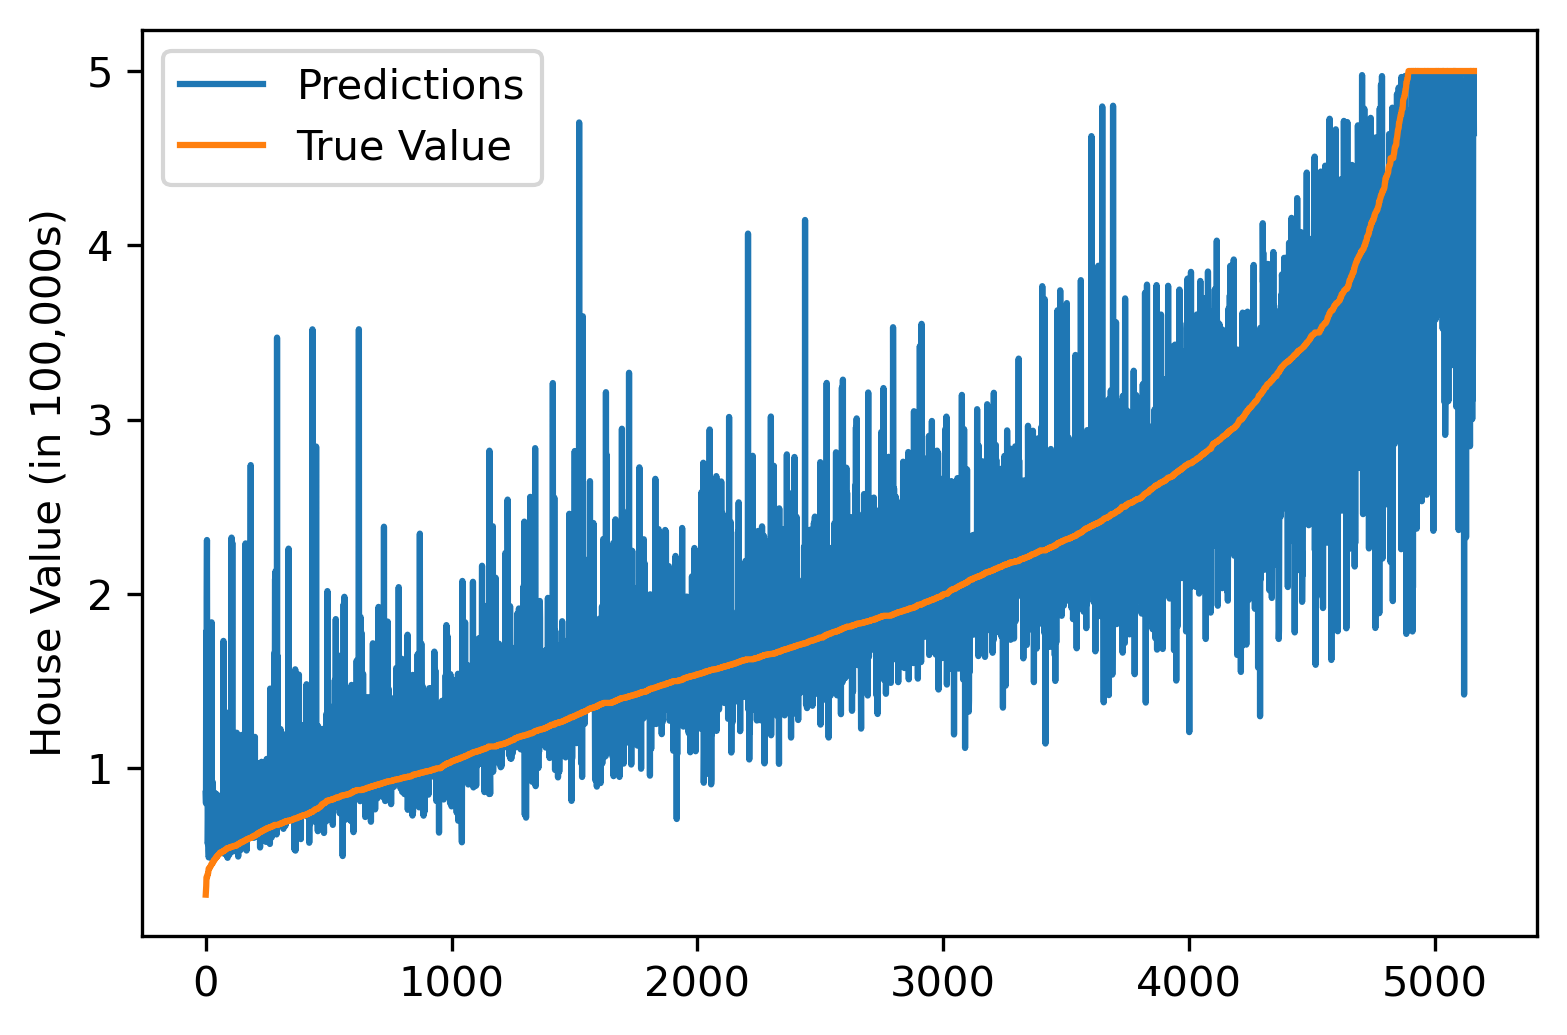

In [88]:
plot_sorted_results(predictions, testy)

In [97]:
# What is most important in the regression?
sorted(list(zip(columns, rf.feature_importances_)), key=(lambda x: x[1]))

[('AveBedrms', 0.029257232408781517),
 ('Population', 0.0322811472555122),
 ('AveRooms', 0.040876775965167284),
 ('HouseAge', 0.055917026549652665),
 ('Longitude', 0.0885497067010998),
 ('Latitude', 0.09178219094526603),
 ('AveOccup', 0.13844334618142476),
 ('MedInc', 0.5228925739930957)]

Note that the income is the most important variable!

In [102]:
# https://scikit-learn.org/stable/modules/permutation_importance.html
#https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
from sklearn.inspection import permutation_importance
r = permutation_importance(rf, trainX, trainy,
                           n_repeats=30,
                           random_state=0)

In [103]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{columns[i]:<8}"
          f"{r.importances_mean[i]:.3f}"
          f" +/- {r.importances_std[i]:.3f}")

MedInc  0.904 +/- 0.009
Latitude0.497 +/- 0.005
Longitude0.381 +/- 0.003
AveOccup0.308 +/- 0.004
HouseAge0.124 +/- 0.002
AveRooms0.062 +/- 0.001
Population0.036 +/- 0.001
AveBedrms0.034 +/- 0.001


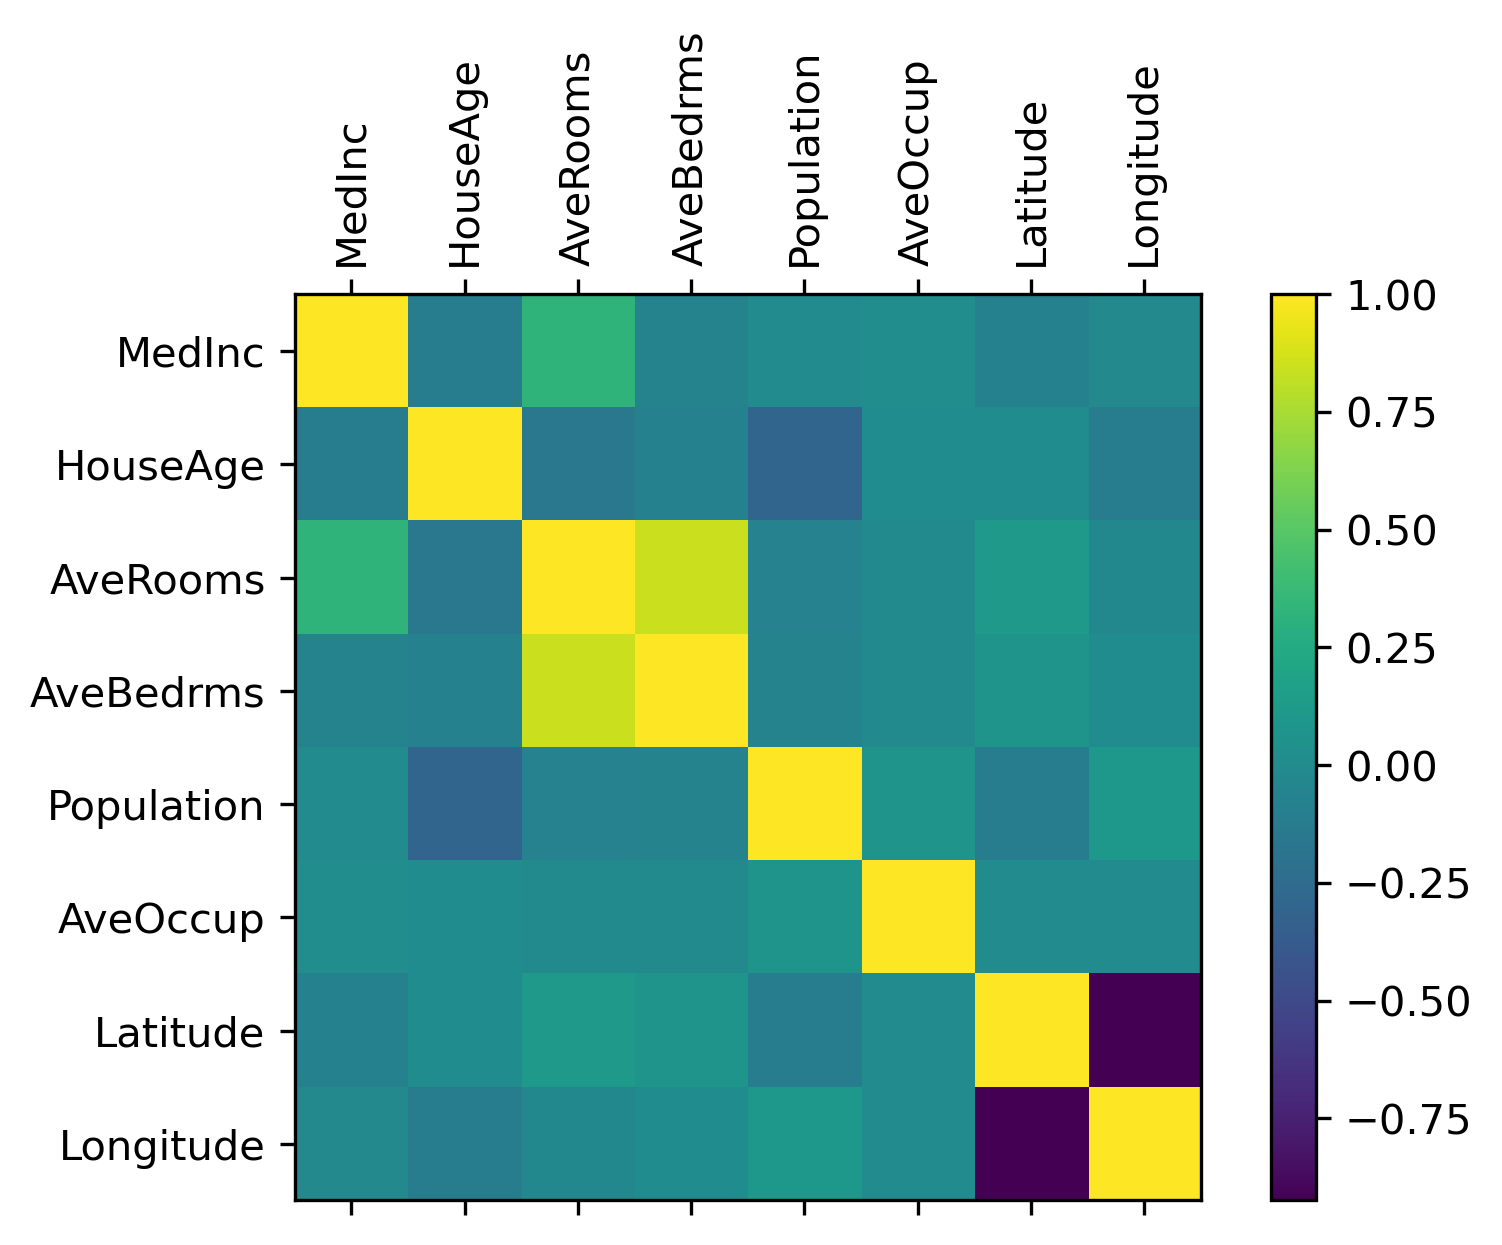

In [89]:
correlations = df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, interpolation='nearest')
fig.colorbar(cax)
ax.set_xticklabels([''] + columns, rotation="vertical")
ax.set_yticklabels([''] + columns)
plt.show()

In [93]:
# Very different results from the tree importance, maybe there is severe multicollinearity in our data?
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df
constant = np.ones(len(X))
constant = pd.Series(constant, name="Constant")
X['Constant'] = constant
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data)  # Very high VIF for latitude and longitude...

      feature           VIF
0      MedInc      2.501295
1    HouseAge      1.241254
2    AveRooms      8.342786
3   AveBedrms      6.994995
4  Population      1.138125
5    AveOccup      1.008324
6    Latitude      9.297624
7   Longitude      8.962263
8    Constant  17082.623698


In [62]:
# New approach
import shap

In [108]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(trainX[:1000])  # look at less data in the interest of time

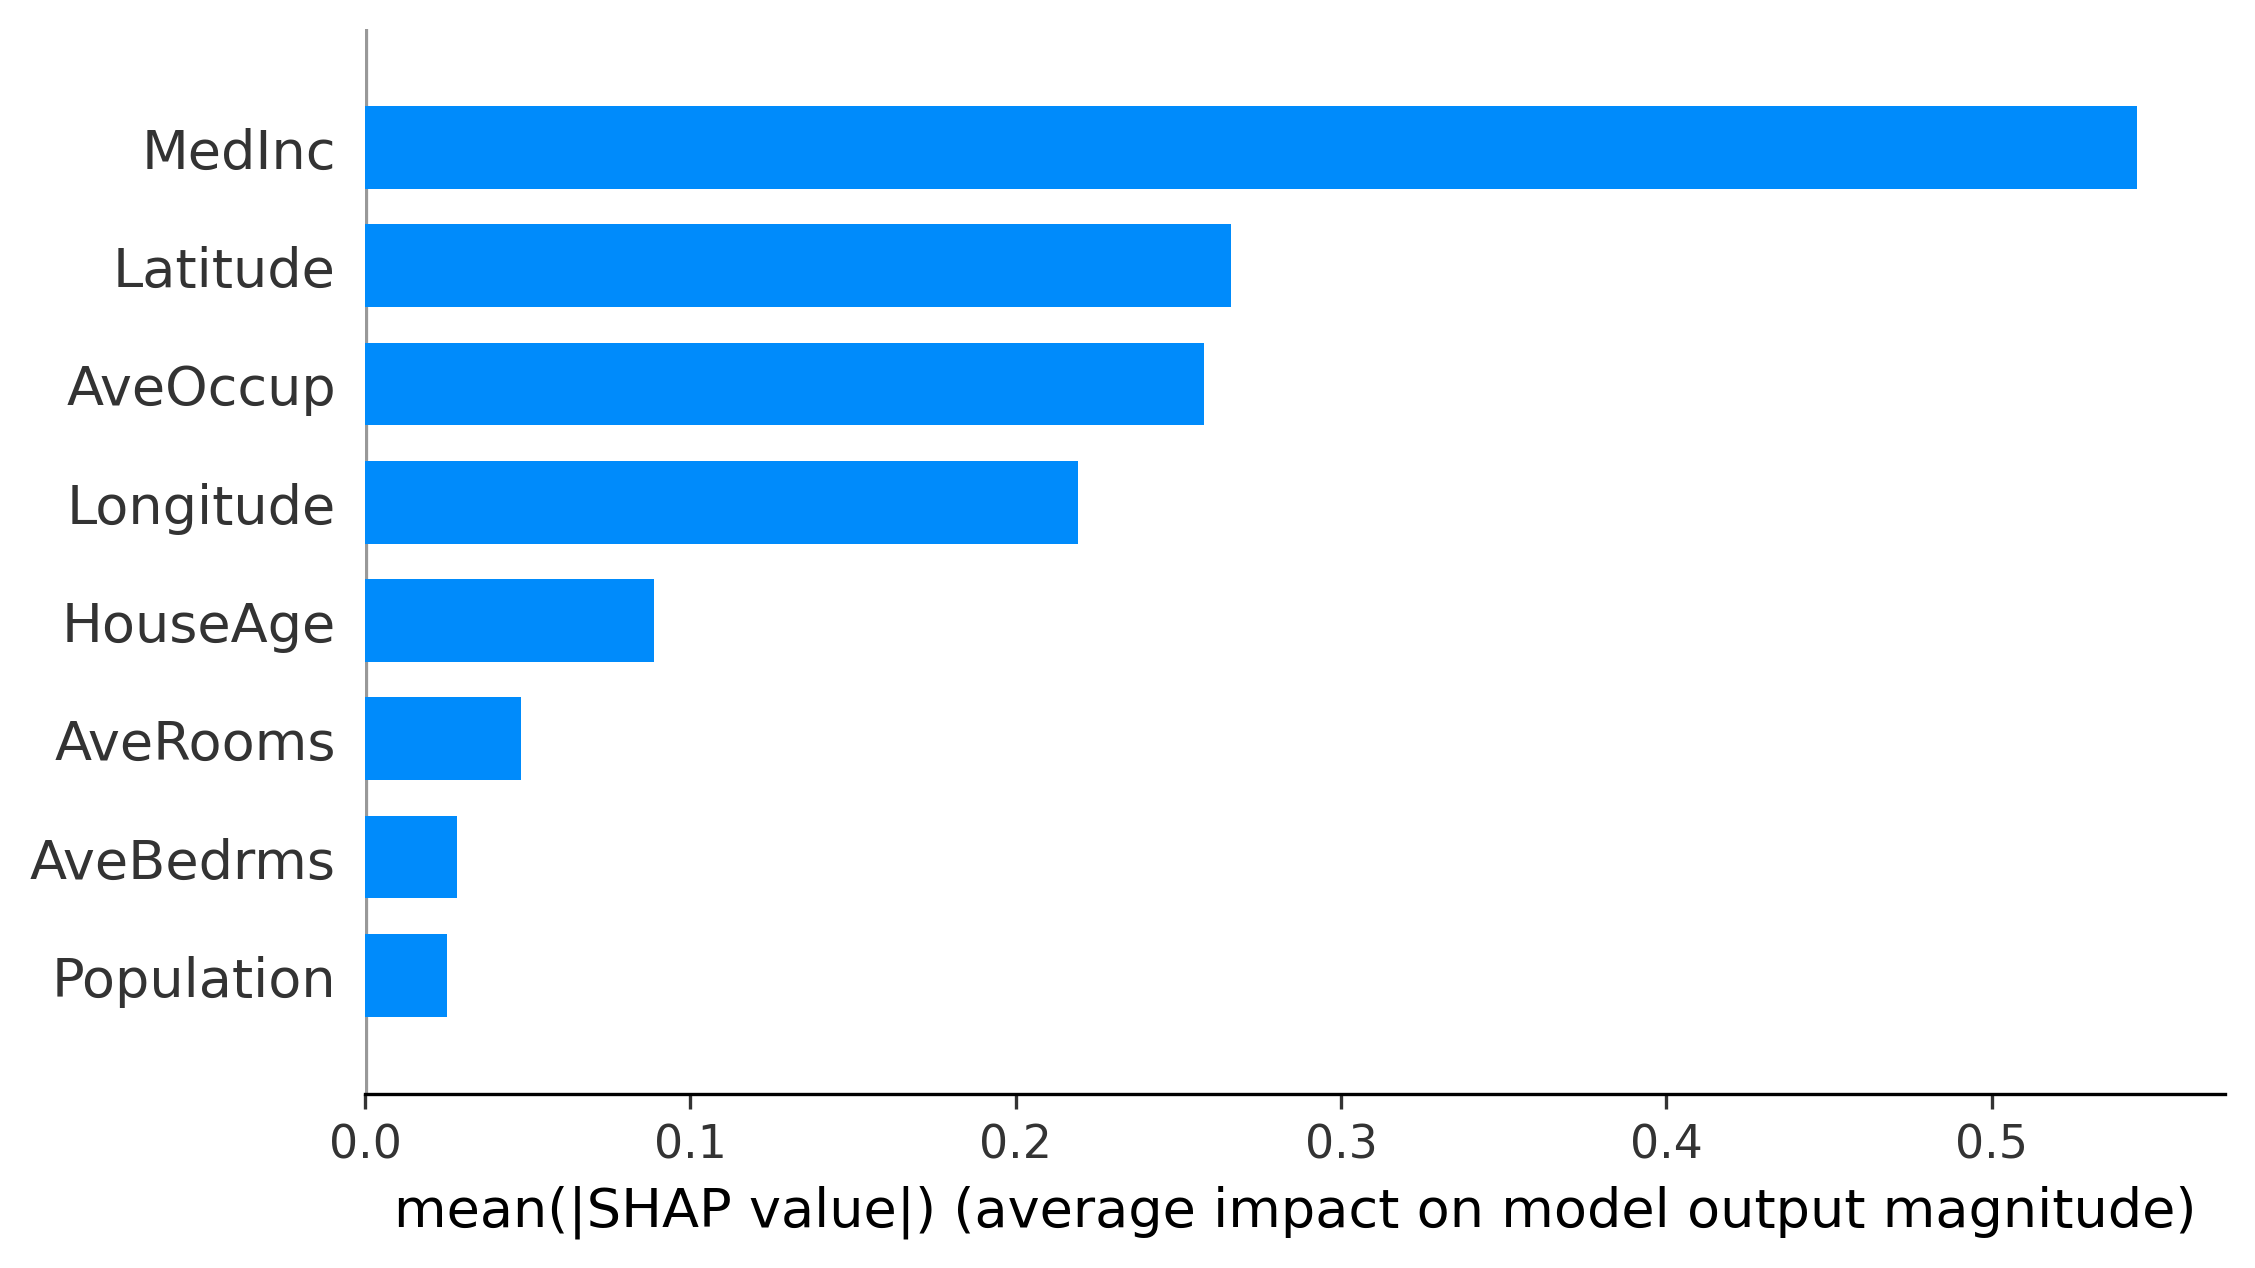

In [109]:
shap.summary_plot(shap_values, trainX, feature_names=columns, plot_type="bar")

In [110]:
sorted(list(zip(columns, np.mean(np.abs(shap_values), axis=0)/np.sum(np.mean(np.abs(shap_values), axis=0)))), key=(lambda x: x[1]))

[('Population', 0.01699705039896045),
 ('AveBedrms', 0.019106668933763366),
 ('AveRooms', 0.0323408208028392),
 ('HouseAge', 0.060106373589322255),
 ('Longitude', 0.14825376525503148),
 ('AveOccup', 0.17448235049214791),
 ('Latitude', 0.18011893484847744),
 ('MedInc', 0.36859403567945787)]

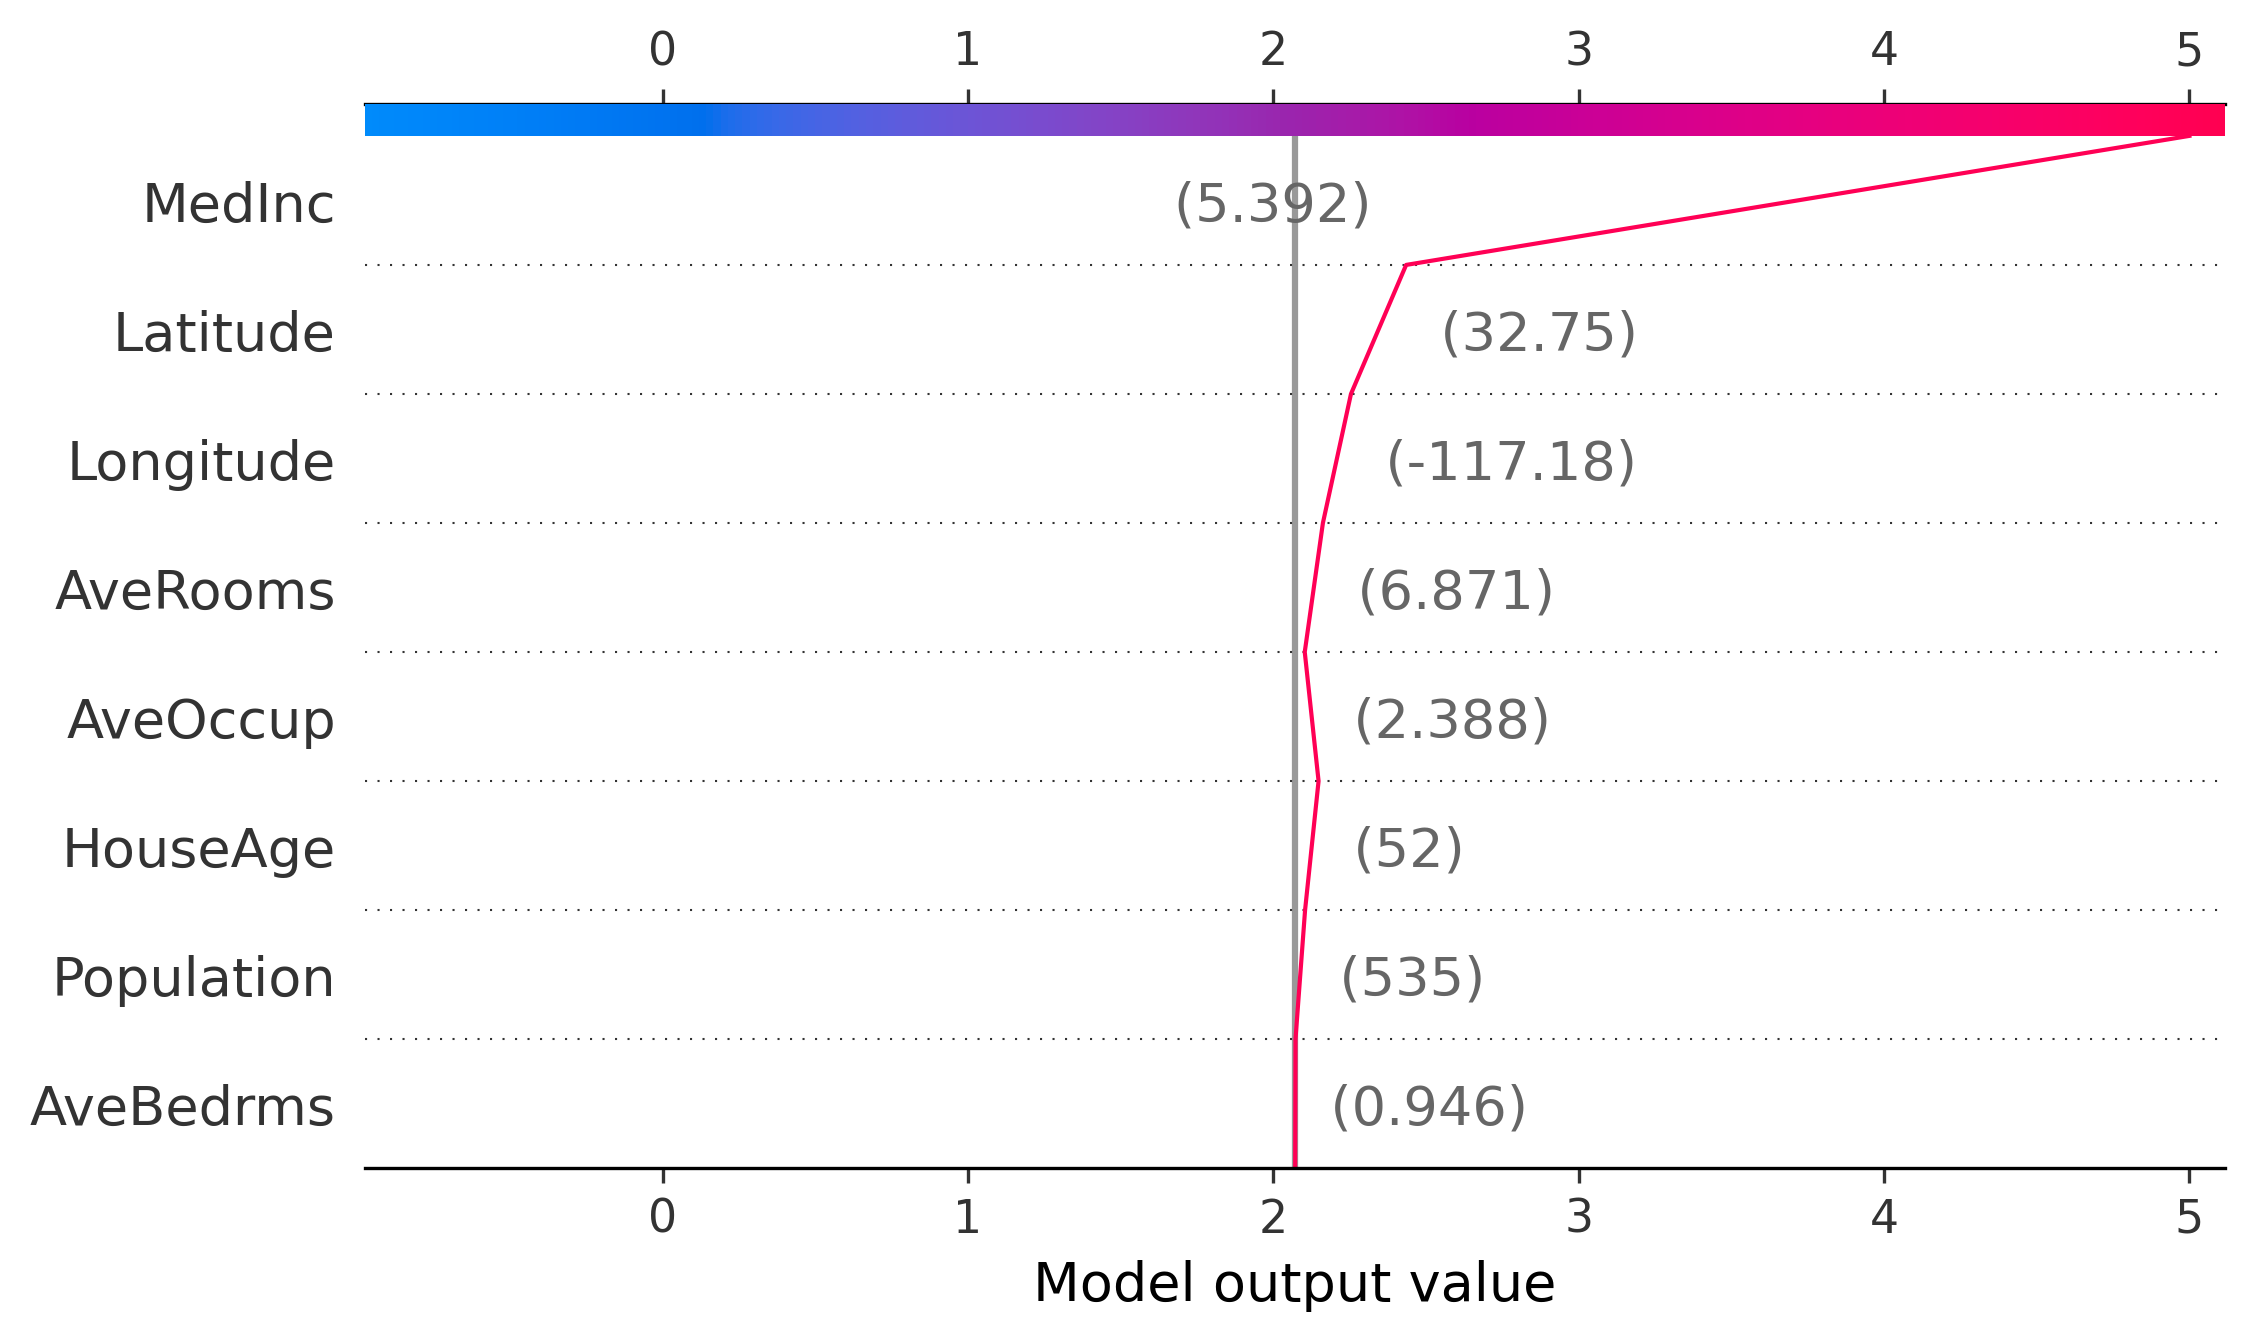

In [116]:
shap.initjs()
i = 3
X_test = testX.to_numpy()
shap.decision_plot(explainer.expected_value, shap_values[i], X_test[i], feature_names = columns)